Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Bingyan Liu"

---

In [2]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

! pip install pot

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_two_moons(n_samples=5000, noise=0.1):
    X, y = make_moons(n_samples=n_samples, noise=noise)
    X = (X - X.mean()) / X.std()
    return torch.tensor(X, dtype=torch.float32, device=device)

seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_data = load_two_moons(5000, noise=0.05)
dataset = TensorDataset(x_data)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
train_data_np = x_data.cpu().numpy()

x_data = load_two_moons(1000, noise=0.05)
val1_data_np = x_data.cpu().numpy()

x_data = load_two_moons(1000, noise=0.2)
val2_data_np = x_data.cpu().numpy()

In [3]:
import ot

def calc_w_distance(X, Y):
    assert X.shape == Y.shape, "The shape of X and Y do not match"
    # Compute the pairwise squared Euclidean distance matrix (cost matrix)
    #M = np.sum((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2, axis=2)
    M = ot.dist(X, Y, metric='euclidean')

    # Uniform weights (each point has equal probability)
    a = np.ones(X.shape[0]) / X.shape[0]
    b = np.ones(Y.shape[0]) / Y.shape[0]

    # Solve the optimal transport problem to compute W2 distance
    W2_distance = ot.emd2(a, b, M)  # Returns squared Wasserstein-2 distance
    #W2_distance = np.sqrt(W2_squared)  # Take square root to get W2

    print(f"Wasserstein-1 Distance: {W2_distance:.4f}")
    return W2_distance


def plot_two_moon(X, model_name):
    plt.figure(figsize=(4, 4))
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5, edgecolors='k')
    plt.title(model_name)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.tight_layout()
    plt.show()

In [4]:
#plot_two_moon(train_data_np, "Training Data")
#plot_two_moon(val1_data_np, "Validation Data 1")
#plot_two_moon(val2_data_np, "Validation Data 2")

# NICE

In [5]:
# DO NOT CHANGE THIS CELL
class StandardLogistic(torch.distributions.Distribution):
    """Standard logistic distribution.
    """
    def __init__(self):
        super(StandardLogistic, self).__init__(validate_args=False)

    def log_prob(self, x):
        """Computes data log-likelihood.
        Args:
            x: input tensor.
        Returns:
            log-likelihood.
        """
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        """Samples from the distribution.
        Args:
            size: number of samples to generate.
        Returns:
            samples.
        """
        z = torch.distributions.Uniform(0., 1.).sample(size)
        return torch.log(z) - torch.log(1. - z)

class AdditiveCouplingLayer(nn.Module):    
    def __init__(self, input_dim, hidden_dim, num_layers, partition):
        super().__init__()
        assert partition in ['odd', 'even']
        self.partition = partition
        _get_even = lambda xs: xs[:, 0::2]
        _get_odd = lambda xs: xs[:, 1::2]
        if (partition == 'even'):
            self._first = _get_even
            self._second = _get_odd
        else:
            self._first = _get_odd
            self._second = _get_even
        
        _modules = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers):
            _modules.append(nn.Linear(hidden_dim, hidden_dim) )
            _modules.append(nn.ReLU())
        _modules.append(nn.Linear(hidden_dim, input_dim) )
        self.net = nn.Sequential(*_modules)

    
    def forward(self, x):
        """Map an input through the partition and nonlinearity.
        y1 = x1
        y2 = x2 + m(x1)
        """
        # YOUR CODE HERE
        x1 = self._first(x)
        x2 = self._second(x)
        y1 = x1
        y2 = x2 + self.net(x1)
        out = torch.zeros_like(x)
        out[:, 0::2] = y1 if self.partition == 'even' else y2
        out[:, 1::2] = y2 if self.partition == 'even' else y1
        return out

    def inverse(self, y):
        """Inverse mapping through the layer. Gradients should be turned off for this pass.
        x1 = y1
        x2 = y2 - m(y1)
        """
        # YOUR CODE HERE
        y1 = self._first(y)
        y2 = self._second(y)
        x1 = y1
        x2 = y2 - self.net(y1)
        out = torch.zeros_like(y)
        out[:, 0::2] = x1 if self.partition == 'even' else x2
        out[:, 1::2] = x2 if self.partition == 'even' else x1
        return out


In [6]:

class NICEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_m_layers, prior):
        super(NICEModel, self).__init__()
        assert (input_dim % 2 == 0)
        self.input_dim = input_dim
        # define network
        half_dim = int(input_dim / 2)
        self.layer1 = AdditiveCouplingLayer(half_dim, hidden_dim, num_m_layers, 'odd')
        self.layer2 = AdditiveCouplingLayer(half_dim, hidden_dim, num_m_layers, 'even')
        self.layer3 = AdditiveCouplingLayer(half_dim, hidden_dim, num_m_layers, 'odd')
        self.layer4 = AdditiveCouplingLayer(half_dim, hidden_dim, num_m_layers, 'even')
        self.scaling_diag = nn.Parameter(torch.zeros(1, input_dim), requires_grad=True)
        self.prior = prior
        self.register_buffer('_dummy', torch.empty([0, ]))

    def forward(self, x):
        """Forward pass through all invertible coupling layers.
        Args:
            x: Input data. float tensor of shape (batch_size, input_dim).
        Returns:
            z: Latent variable. float tensor of shape (batch_size, input_dim).
        """
        # YOUR CODE HERE
        z = x
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4]:
            z = layer(z)
        z = z * torch.exp(self.scaling_diag)
        return z


    def inverse(self, z):
        """Invert a set of draws from logistic prior
        Args:
            z: Latent variable. float tensor of shape (batch_size, input_dim).
        Returns:
            x: Generated data. float tensor of shape (batch_size, input_dim).
        """
        with torch.no_grad():
            # YOUR CODE HERE
            z = z * torch.exp(-self.scaling_diag)
            for layer in [self.layer4, self.layer3, self.layer2, self.layer1]:
                z = layer.inverse(z)
            x = z
        return x
    
    def log_prob(self, x):
        """Computes data log-likelihood. (See Section 3.3 in the NICE paper.)
        Args:
            x: input minibatch.
        Returns:
            log_p: log-likelihood of input.
        """
        # YOUR CODE HERE
        z = self.forward(x)
        log_det_jacobian = self.scaling_diag.sum()
        log_p = self.prior.log_prob(z).sum(dim=1) + log_det_jacobian
        return log_p
    
    def sample(self, num_samples):
        """Generates samples.
        Args:
            num_samples: number of samples to generate.
        Returns:
            x: samples from the data space X.
        """
        z = torch.randn(num_samples, self.input_dim, device=self._dummy.device)
        x = self.inverse(z).detach().cpu().numpy()
        return x

In [7]:
# DO NOT CHANGE THIS CELL
INPUT_DIM = 2
HIDDEN_DIM = 32
NUM_M_LAYERS = 3
MAX_ITERS = 20000

def inf_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()
            
train_loader = inf_iterator(dataloader)

prior = StandardLogistic()
nice_ckpt = 'model_nice_2025.pt'
best_loss = np.inf
if not os.path.exists(nice_ckpt):
    model_nice = NICEModel(INPUT_DIM, HIDDEN_DIM, num_m_layers=NUM_M_LAYERS, prior=prior).to(device)
    train_op = optim.Adam(model_nice.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-4)

    model_nice.train()
    for i in range(1, MAX_ITERS + 1):
        batch = next(train_loader)
        batch = batch[0].to(device)

        log_p = model_nice.log_prob(batch)
        loss = -log_p.mean()

        train_op.zero_grad()
        loss.backward()
        train_op.step()
        if loss < best_loss:
            best_loss = loss
            print(f'iter: {i} loss: {loss:.4f}')
            best_model = copy.deepcopy(model_nice)
        if i % 1000 == 0:
            print(f'iter: {i} loss: {loss:.4f}')
    torch.save(best_model.state_dict(), nice_ckpt)

def sample_nice(model_nice, num_samples):
    samples = model_nice.sample(num_samples)
    return samples

iter: 1 loss: 3.2138
iter: 2 loss: 3.1722
iter: 6 loss: 3.1685
iter: 14 loss: 3.1537
iter: 17 loss: 3.1194
iter: 29 loss: 3.1149
iter: 31 loss: 3.1036
iter: 37 loss: 3.0988
iter: 39 loss: 3.0715
iter: 52 loss: 3.0664
iter: 55 loss: 3.0469
iter: 56 loss: 3.0221
iter: 86 loss: 2.9930
iter: 95 loss: 2.9739
iter: 98 loss: 2.9588
iter: 105 loss: 2.9579
iter: 110 loss: 2.9487
iter: 116 loss: 2.9425
iter: 120 loss: 2.8919
iter: 145 loss: 2.8782
iter: 149 loss: 2.8771
iter: 150 loss: 2.8746
iter: 156 loss: 2.8643
iter: 157 loss: 2.8621
iter: 160 loss: 2.8030
iter: 170 loss: 2.7924
iter: 179 loss: 2.7677
iter: 185 loss: 2.7631
iter: 187 loss: 2.7600
iter: 191 loss: 2.7321
iter: 198 loss: 2.7233
iter: 200 loss: 2.7084
iter: 206 loss: 2.6911
iter: 212 loss: 2.6803
iter: 216 loss: 2.6507
iter: 225 loss: 2.6400
iter: 229 loss: 2.6373
iter: 231 loss: 2.6284
iter: 233 loss: 2.6239
iter: 234 loss: 2.6028
iter: 237 loss: 2.6018
iter: 239 loss: 2.5937
iter: 243 loss: 2.5799
iter: 252 loss: 2.5299
iter: 

Wasserstein-1 Distance: 0.6406
Wasserstein-1 Distance: 0.6769


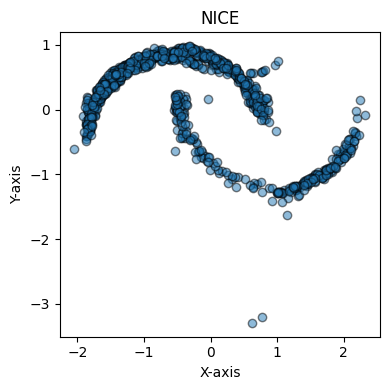

In [ ]:
# DO NOT CHANGE THIS CELL
samples = sample_nice(best_model, 1000)
calc_w_distance(samples, val1_data_np)
calc_w_distance(samples, val2_data_np)
#plot_two_moon(samples, "NICE")

In [9]:
# HIDDEN TEST CELL, DO NOT CHANGE

# WGAN

In [10]:
# DO NOT CHANGE THIS CELL
import torch
import torch.nn as nn
# Feel free to use these variables
DIM = 512  # Model dimensionality
# Gaussian noise, as in the plots in the paper
LAMBDA = .1  # Smaller lambda seems to help for toy tasks specifically
CRITIC_ITERS = 5  # How many critic iterations per generator iteration
BATCH_SIZE = 128  # Batch size
ITERS = 500  # how many generator iterations to train for
one = torch.tensor(1, dtype=torch.float).to(device)
mone = one * -1
one = one.to(device)
mone = mone.to(device)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        main = nn.Sequential(
            nn.Linear(2, DIM),
            nn.ReLU(True),
            nn.Linear(DIM, DIM),
            nn.ReLU(True),
            nn.Linear(DIM, DIM),
            nn.ReLU(True),
            nn.Linear(DIM, 2),
        )
        self.main = main

    def forward(self, noise, real_data):
        output = self.main(noise)
        return output


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        main = nn.Sequential(
            nn.Linear(2, DIM),
            nn.ReLU(True),
            nn.Linear(DIM, DIM),
            nn.ReLU(True),
            nn.Linear(DIM, DIM),
            nn.ReLU(True),
            nn.Linear(DIM, 1),
        )
        self.main = main

    def forward(self, inputs):
        output = self.main(inputs)
        return output.view(-1)

In [11]:
def calc_gradient_penalty(netD, real_data, fake_data):
    # YOUR CODE HERE
    alpha = torch.rand(real_data.size(0), 1, device=device)
    alpha = alpha.expand(real_data.size())
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)

    # Get discriminator output for interpolated samples
    disc_interpolates = netD(interpolates)
    
    # Calculate gradients
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Calculate gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [12]:
wgan_ckpt = 'model_wgan_2025.pt'
seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
netG = Generator()
netD = Discriminator()

netD = netD.to(device)
netG = netG.to(device)

optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))

if not os.path.exists(wgan_ckpt):
    for iteration in range(ITERS):
        ############################
        # (1) Update D network
        ###########################
        # YOUR CODE HERE
        for p in netD.parameters():
            p.requires_grad = True
        for p in netG.parameters():
            p.requires_grad = False
            
        for d_iter in range(CRITIC_ITERS):
            netD.zero_grad()
            real_data = next(iter(dataloader))[0].to(device)
            
            noise = torch.randn(real_data.size(0), 2, device=device)
            fake_data = netG(noise, None)
            
            D_real = netD(real_data)
            D_fake = netD(fake_data)
            gradient_penalty = calc_gradient_penalty(netD, real_data, fake_data)
            D_loss = D_fake.mean() - D_real.mean() + LAMBDA * gradient_penalty
            
            D_loss.backward()
            optimizerD.step()            
        ############################
        # (2) Update G network
        ###########################
        # YOUR CODE HERE
        for p in netD.parameters():
            p.requires_grad = False
        for p in netG.parameters():
            p.requires_grad = True
            
        netG.zero_grad()
        
        noise = torch.randn(real_data.size(0), 2, device=device)
        fake_data = netG(noise, None)
        
        G_loss = -netD(fake_data).mean()
        
        G_loss.backward()
        optimizerG.step()
        
        if iteration % 100 == 0:
            print(f'Iteration {iteration}: D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}')
    torch.save(netG.state_dict(), wgan_ckpt)

In [13]:
def sample_wgan(netG, num_samples):
    """ Sampler from the WGAN model from an isotropic Gaussian distribution """
    # YOUR CODE HERE
    noise = torch.randn(num_samples, INPUT_DIM, device=device)
    samples = netG(noise, None).detach().cpu().numpy()
    return samples

samples = sample_wgan(netG, 1000)
#plot_two_moon(samples, "WGAN")
calc_w_distance(samples, val1_data_np)
calc_w_distance(samples, val2_data_np)

Wasserstein-1 Distance: 1.2792
Wasserstein-1 Distance: 1.2690


1.268953247301281

In [14]:
# HIDDEN TEST CELL, DO NOT CHANGE

# DDPM

In [15]:
ddpm_ckpt = 'model_ddpm_2025.pt'
betas = torch.linspace(0.0001, 0.02, 100, device=device)

def q_sample(x_0, t, betas):
    """Adds noise to x_0 at timestep t."""

    # YOUR CODE HERE
    alpha = 1 - betas
    alpha_bar = torch.cumprod(alpha, dim=0)
    
    alpha_bar_t = alpha_bar[t].view(-1, 1)
    
    noise = torch.randn_like(x_0)

    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    
    return x_t, noise

class FeedForward(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, 10),
            nn.SiLU(),
            nn.Linear(10, input_dim)
        )
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        x = self.encoder(x)
        x = self.decoder(x)
        return x + self.mlp(t.float().unsqueeze(-1))

def train_ddpm(model, betas, n_epochs=100, lr=2e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    # YOUR CODE HERE
    alpha = 1 - betas
    alpha_bar = torch.cumprod(alpha, dim=0)
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        for batch in dataloader:
            x_0 = batch[0].to(device)
            batch_size = x_0.size(0)
            
            t = torch.randint(0, len(betas), (batch_size,), device=device)
            x_t, noise = q_sample(x_0, t, betas)
            
            predicted_noise = model(x_t, t)
            
            loss = F.mse_loss(predicted_noise, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}')

    torch.save(model.state_dict(), ddpm_ckpt)

model = FeedForward().to(device)
if not os.path.exists(ddpm_ckpt):
    train_ddpm(model, betas, n_epochs=100, lr=2e-3)

In [16]:
# Generate new samples
alpha_cumprod = torch.sqrt((1 - betas).cumprod(dim=0))

def sample_ddpm(model, num_samples, betas):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 2, device=device)
        
        alpha = 1 - betas
        alpha_bar = torch.cumprod(alpha, dim=0)
        
        for t in reversed(range(len(betas))):
            alpha_t = alpha[t]
            beta_t = betas[t]
            
            predicted_noise = model(x, torch.tensor([t], device=device).repeat(num_samples))
            
            mean = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar[t])) * predicted_noise)
            if t > 0:
                variance = beta_t
                noise = torch.randn_like(x)
                x = mean + torch.sqrt(variance) * noise
            else:
                x = mean
                
        return x.cpu().numpy()

In [17]:
#samples = sample_ddpm(model, 1000, betas)
#plot_two_moon(samples, "DDPM")
#calc_w_distance(samples, val1_data_np)
#calc_w_distance(samples, val2_data_np)

In [18]:
# HIDDEN TEST CELL, DO NOT CHANGE